In [86]:
from cmdstanpy import CmdStanModel

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

### Load and analyze airline data from a CSV file.

In [87]:
airline_df = pd.read_csv('Airline_data.csv')
airline_df.head()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3863.0
1,1977,25,516,4300.0
2,1978,31,754,5027.0
3,1979,31,877,5481.0
4,1980,22,814,5814.0


In [88]:
airline_df.columns

Index(['Year', 'Fatal accidents', 'Passenger deaths',
       'Miles flown [100 mln miles]'],
      dtype='object')

In [89]:
print('mean fatal accidents:', airline_df['Fatal accidents'].mean())
print('std Miles flown [100 mln miles]: {}'.format(round(airline_df['Miles flown [100 mln miles]'].std(), 2)))
# The value of miles flown [100 million miles] was very large, 
# so I decided to change the unit to 100 billion.
airline_df['Miles flown [100 bn miles]'] = airline_df['Miles flown [100 mln miles]']/1000
print('std Miles flown [100 bn miles]: {}'.format(round(airline_df['Miles flown [100 bn miles]'].std(), 2)))

mean fatal accidents: 23.8
std Miles flown [100 mln miles]: 1117.77
std Miles flown [100 bn miles]: 1.12


### Prior predictive checks

In [90]:
model = CmdStanModel(stan_file='airline_model_0.stan')

# sample from the posterior distribution
samples = model.sample(data={},
                       fixed_param=True, 
                       iter_sampling=1000,
                       iter_warmup=0,
                       seed=20001113, 
                       chains = 1)
df = samples.draws_pd()
df.head()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,alpha,theta,n,lambda,y
0,0.0,0.0,3.82196,0.348015,-1.32203,28.84320,26.0
1,0.0,0.0,3.19867,0.262467,-0.65292,20.64140,27.0
2,0.0,0.0,3.28081,0.415653,-1.04729,17.21020,6.0
3,0.0,0.0,3.09181,0.486661,-1.67725,9.73338,8.0
4,0.0,0.0,1.96654,0.527360,0.42302,8.93189,14.0


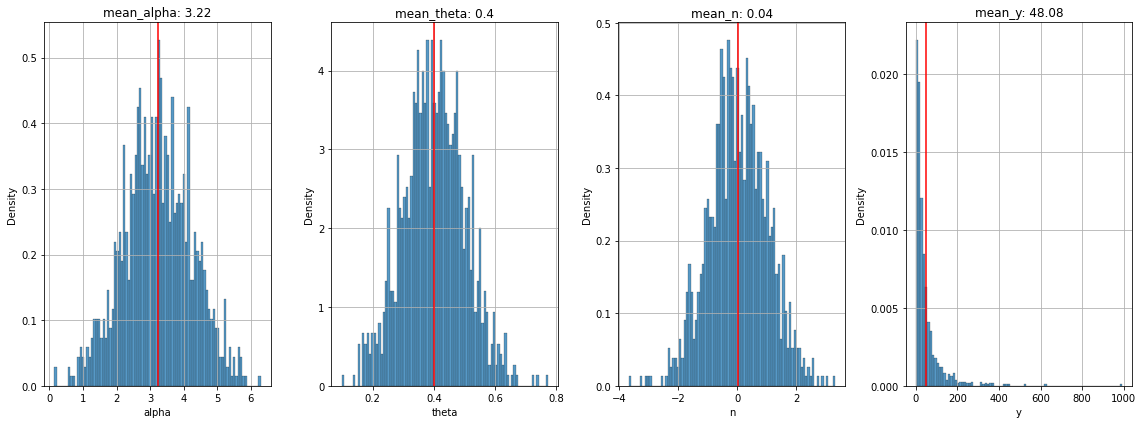

In [91]:
_, ax = plt.subplots(nrows=1, ncols=4, figsize=[16,6])

for idx_col, col in enumerate(['alpha', 'theta','n', 'y']):
    sns.histplot(data=df, x=df[col], stat="density", ax=ax[idx_col], bins=90)
    ax[idx_col].axvline(df[col].mean(), color='red')
    ax[idx_col].set_title('mean_{0}: {1}'.format(col, round(df[col].mean(),2)))
    ax[idx_col].grid()
plt.tight_layout()
plt.show()

### Posterior

In [95]:
model_fit=CmdStanModel(stan_file='airline_model_0_fit.stan', compile=True)

data_sim={"N": airline_df.shape[0], 
          "n_i": airline_df["Miles flown [100 bn miles]"].values,
          "y": airline_df["Fatal accidents"].values}

fit_samples = model_fit.sample(data=data_sim)
df_fit = fit_samples.draws_pd()
df_fit.head()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,theta,y_pred[1],y_pred[2],y_pred[3],y_pred[4],y_pred[5],y_pred[6],y_pred[7],y_pred[8],y_pred[9],y_pred[10]
0,508.154,0.976977,0.141079,4.0,17.0,0.0,-507.609,3.05025,0.031324,36.0,16.0,25.0,14.0,26.0,14.0,17.0,30.0,33.0,17.0
1,508.284,0.891078,0.141079,2.0,3.0,0.0,-507.252,3.04562,0.030423,27.0,26.0,29.0,31.0,29.0,31.0,22.0,22.0,24.0,43.0
2,507.026,0.854130,0.141079,2.0,7.0,0.0,-506.863,2.92670,0.022341,22.0,23.0,27.0,22.0,22.0,14.0,17.0,22.0,32.0,17.0
3,506.917,0.995764,0.141079,3.0,15.0,0.0,-506.385,2.93401,0.060370,23.0,13.0,21.0,25.0,22.0,31.0,34.0,20.0,30.0,19.0
4,506.562,0.941602,0.141079,2.0,3.0,0.0,-506.141,2.84324,0.033931,22.0,15.0,28.0,25.0,26.0,19.0,20.0,23.0,19.0,18.0


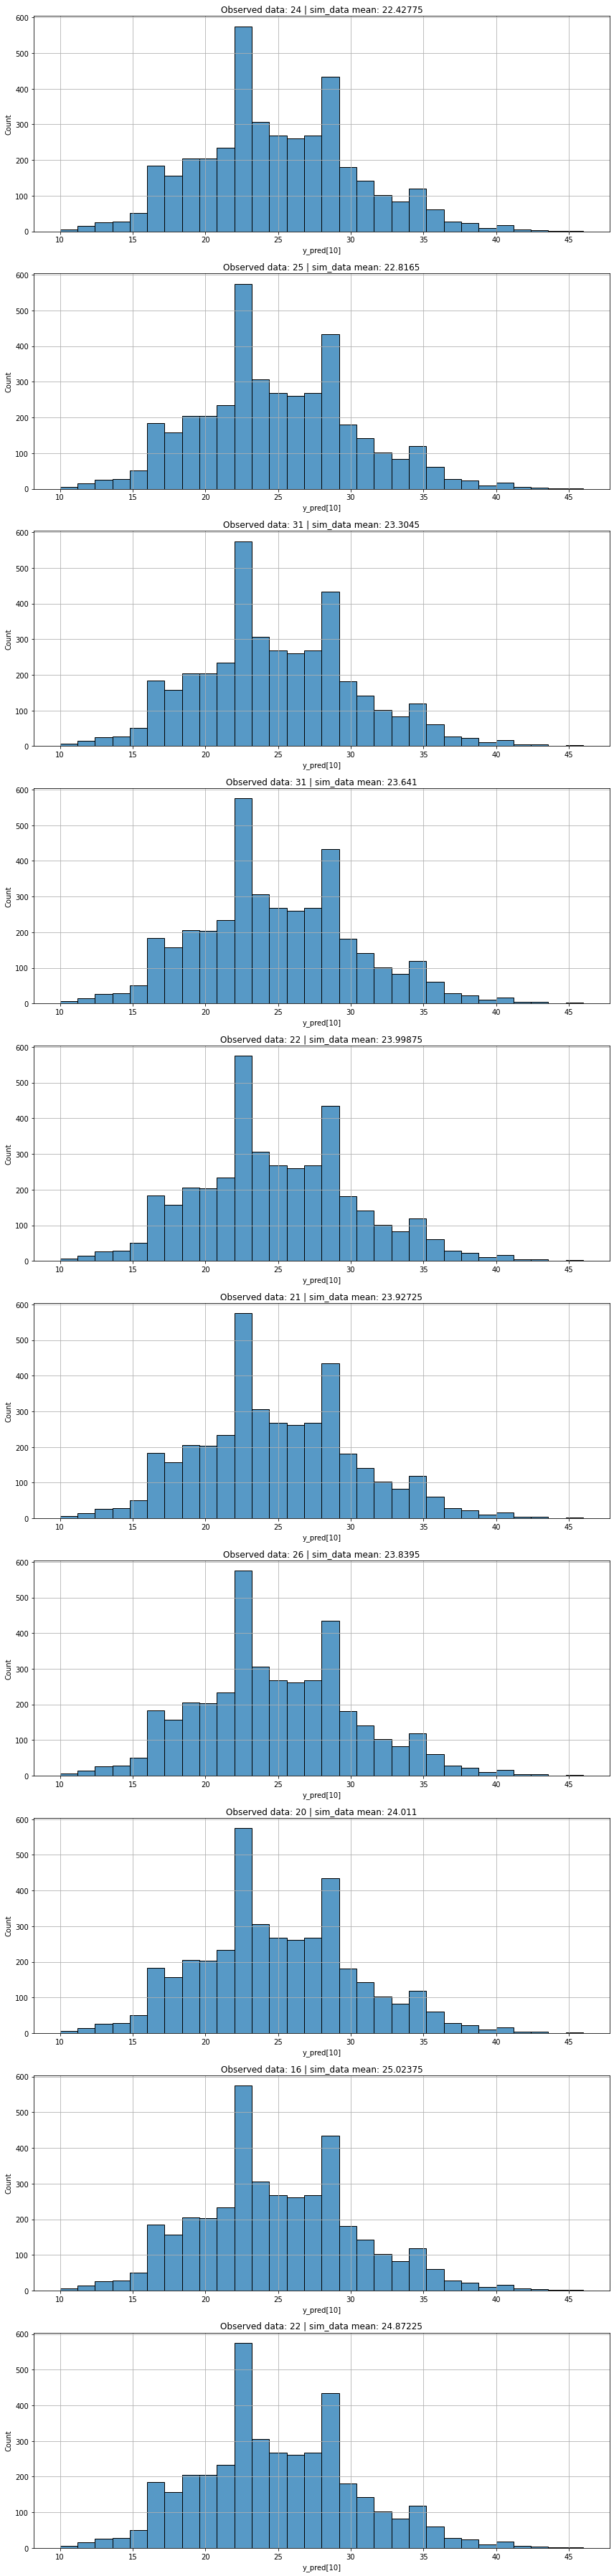

In [97]:
_, ax = plt.subplots(nrows=10, figsize=(12, 10*5))

for idx, year in enumerate(np.arange(airline_df.Year.min(), airline_df.Year.max() + 1, step=1)):
    ax[idx].grid()
    sns.histplot(df_fit[f'y_pred[{i}]'], bins=30, ax=ax[idx])
    ax[idx].set_title(f"Observed data: {airline_df['Fatal accidents'][idx]} | sim_data mean: {df_fit[f'y_pred[{idx + 1}]'].mean()}")
plt.tight_layout()
plt.show()
    

### Improving model

In [98]:
model_fit=CmdStanModel(stan_file='airline_model_1_fit.stan', compile=True)

fit_samples = model_fit.sample(data=data_sim)
df_fit = fit_samples.draws_pd()
df_fit.head()

INFO:cmdstanpy:compiling stan file /home/5_Using_link_functions_to_create_generalized_linear_models/airline_model_1_fit.stan to exe file /home/5_Using_link_functions_to_create_generalized_linear_models/airline_model_1_fit
INFO:cmdstanpy:compiled model executable: /home/5_Using_link_functions_to_create_generalized_linear_models/airline_model_1_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/5_Using_link_functions_to_create_generalized_linear_models/airline_model_1_fit.hpp /home/5_Using_link_functions_to_create_generalized_linear_models/airline_model_1_fit.stan
Warning in '/home/5_Using_link_functions_to_create_generalized_linear_models/airline_model_1_fit.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/5_Using_link_functions_to_c


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha[1],alpha[2],alpha[3],...,y_pred[1],y_pred[2],y_pred[3],y_pred[4],y_pred[5],y_pred[6],y_pred[7],y_pred[8],y_pred[9],y_pred[10]
0,510.800,0.707432,0.196682,4.0,31.0,0.0,-502.389,2.73167,2.96956,2.95057,...,29.0,34.0,28.0,37.0,22.0,14.0,21.0,22.0,14.0,17.0
1,510.268,0.938464,0.196682,4.0,15.0,0.0,-506.273,3.02822,2.54318,3.18379,...,22.0,25.0,40.0,32.0,16.0,17.0,33.0,11.0,18.0,14.0
2,511.176,0.999635,0.196682,4.0,31.0,0.0,-507.627,2.94614,2.55454,3.08801,...,29.0,13.0,37.0,35.0,17.0,22.0,25.0,17.0,13.0,15.0
3,508.034,0.948740,0.196682,3.0,7.0,0.0,-506.141,2.96849,2.54936,3.04808,...,27.0,15.0,27.0,41.0,9.0,27.0,23.0,30.0,22.0,26.0
4,511.417,0.972986,0.196682,4.0,15.0,0.0,-504.336,3.08594,2.71103,2.94874,...,32.0,24.0,36.0,41.0,31.0,30.0,25.0,23.0,19.0,27.0


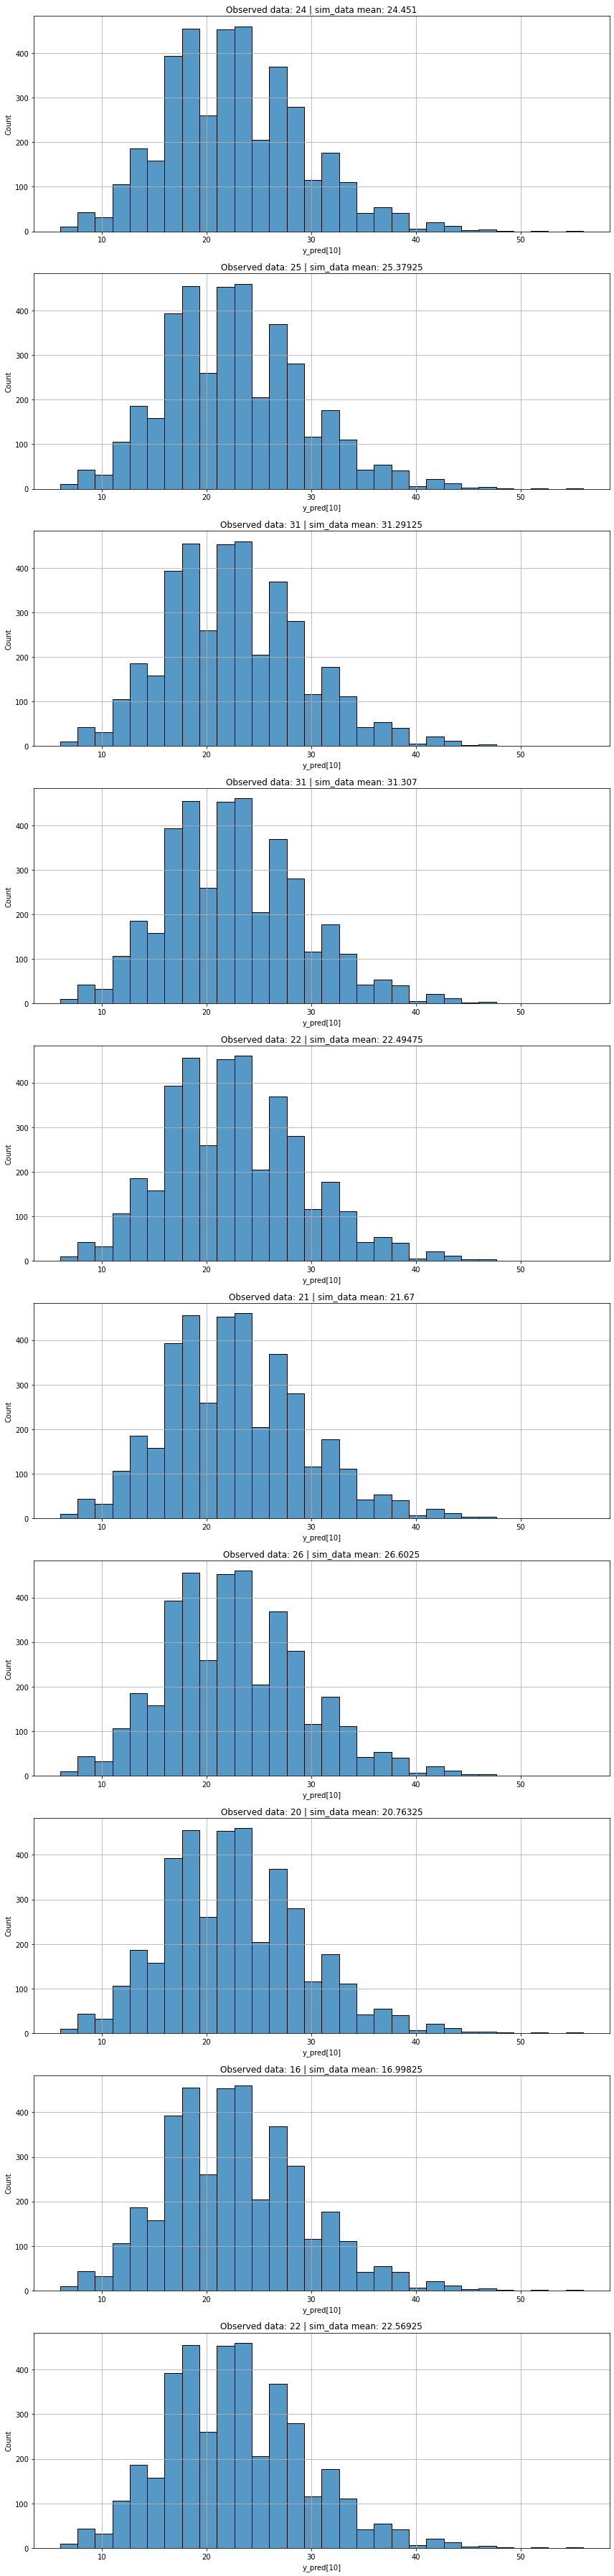

In [99]:
_, ax = plt.subplots(nrows=10, figsize=(12, 10*5))

for idx, year in enumerate(np.arange(airline_df.Year.min(), airline_df.Year.max() + 1, step=1)):
    ax[idx].grid()
    sns.histplot(df_fit[f'y_pred[{i}]'], bins=30, ax=ax[idx])
    ax[idx].set_title(f"Observed data: {airline_df['Fatal accidents'][idx]} | sim_data mean: {df_fit[f'y_pred[{idx + 1}]'].mean()}")
plt.tight_layout()
plt.show()

For the improved model, the data has been much better fitted.